In [1]:
import numpy as np
from numpy.linalg import inv
import matplotlib.pyplot as plt
from estimate import *
import seaborn as sns

plt.rcParams["figure.figsize"] = [8, 6]
plt.rcParams.update({"font.size": 15})

In [2]:
p = 2
B = np.array([[0, 0],
              [2, 0]])
b_causal = B[-1, :-1]
C = inv(np.eye(p) - B)

# Observational stats
# noise variance
S_eps = np.array([[1, 0.5],
               [0.5, 1]])
# data 
Sigma_0 = C @ S_eps @ C.T
Gram_0 = Sigma_0

# Interventional stats
# Unidentifiable case
mu1_noise = np.array([0.5, 0.1]) # the first component = 0.1 or 0.5
S1 = np.array([[1, 0.1],
                  [0.1, 0.05]])

# Identifiable case
# mu1_noise = np.array([0.5, 0]) # the first component = 0.1 or 0.5
# S1 = np.array([[1, 0],
#                   [0, 0]])

mu1 = C @ mu1_noise
# data
Sigma_1 = C @ (S_eps + S1) @ C.T
Gram_1 = Sigma_1 + np.outer(mu1, mu1)

# Test distribution
gram_v_base = (C @ S1 @ C.T + np.outer(mu1, mu1)) / 2

In [3]:
p = 2; n = 1000
eps_0 = np.random.multivariate_normal(np.zeros(p), S_eps, n)
data_0 = eps_0 @ C.T
eps_1 = np.random.multivariate_normal(np.zeros(p), S_eps, n)
delta_1 = np.random.multivariate_normal(mu1_noise, S1, n)
data_1 = (eps_1 + delta_1) @ C.T
print(
    est([data_0, data_1], "drig", gamma=100),
    est([data_0, data_1], "drig", gamma=1),
    est([data_0, data_1], "ols_obs"),
)

[2.1493619] [2.35031172] [2.4848656]


In [4]:
p = 2; n = 1000
gamma = 5
results = None

# Loop through perturbation strengths
perturb_stren = np.linspace(0, 15, 15)

for i in range(100):
    ## simulate data
    eps_0 = np.random.multivariate_normal(np.zeros(p), S_eps, n)
    data_0 = eps_0 @ C.T
    eps_1 = np.random.multivariate_normal(np.zeros(p), S_eps, n)
    delta_1 = np.random.multivariate_normal(mu1_noise, S1, n)
    data_1 = (eps_1 + delta_1) @ C.T
    data = [data_0, data_1]
    
    mse_ours = []
    mse_anchor = []
    mse_pooled = []
    mse_obs = []
    mse_causal = []
    
    ## estimation
    b_drig = est(data, "drig", gamma)
    b_obs = est(data, "ols_obs")
    b_pool = est(data, "ols_pool")
    b_anchor = est(data, "anchor", gamma)
    
    ## evaluate
    n_l = len(perturb_stren)
    for l in perturb_stren:
        Gram_t = Gram_0 + l * gram_v_base
        mse_ours.append(test_mse_pop(Gram_t, b_drig))
        mse_anchor.append(test_mse_pop(Gram_t, b_anchor))
        mse_obs.append(test_mse_pop(Gram_t, b_obs))
        mse_pooled.append(test_mse_pop(Gram_t, b_pool))
        mse_causal.append(test_mse_pop(Gram_t, b_causal))
    
    result = pd.DataFrame({
        "method": np.concatenate([np.repeat("DRIG", n_l), np.repeat("anchor regression", n_l), np.repeat("pooled OLS", n_l), np.repeat("observational OLS", n_l), np.repeat("causal", n_l)], axis=0),
        "perturb_stren": np.tile(perturb_stren, 5),
        "mse": np.array(mse_ours + mse_anchor + mse_pooled + mse_obs + mse_causal)
    })
    results = result if results is None else pd.concat([results, result], ignore_index=True)

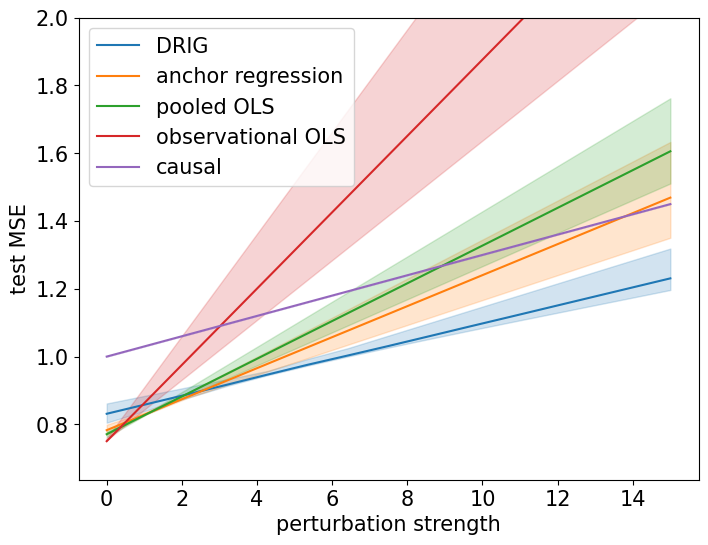

In [5]:
sns.lineplot(data=results, x="perturb_stren", y="mse", hue="method", estimator="median", errorbar=("pi", 95))
plt.legend(); plt.ylabel("test MSE"); plt.xlabel("perturbation strength"); plt.ylim(top=2)
# plt.savefig("./results/illus-unid.pdf", bbox_inches="tight")#-largemeanshift
plt.show()